import necessarry modules

In [38]:
path_reg = r'Video surveillance Dataset.xlsx'
path_class = r'dataset-iris.xlsx'

## **import**

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.manifold import TSNE

## **one hot method**

In [40]:
# create one hot encoded data and unique labels
def one_hot_encoder(data) :
  unique_labels, labels_mapping = np.unique(data[:,-1], return_inverse=True)
  identity_matrix = np.eye(len(unique_labels))
  one_hot_encoded = identity_matrix[labels_mapping]
  return one_hot_encoded, unique_labels
# decode one hotted data
def decode_one_hot(rows, labels):
  indices = np.argmax(rows, axis=1)
  decoded_labels = np.array(labels)[indices]
  return decoded_labels

# change some classes, noisy targets
def add_noise_to_targets(targets, noise_prob):
    # Copy the original targets to avoid modifying them directly
    noisy_targets = np.copy(targets)

    # Determine the number of rows to modify based on the noise probability
    num_rows_to_modify = int(noise_prob * targets.shape[0])

    # Generate random indices for the rows to modify
    indices_to_modify = np.random.choice(targets.shape[0], size=num_rows_to_modify, replace=False)

    # Generate random new classes for the modified rows
    num_classes = targets.shape[1]
    new_classes = np.random.randint(0, num_classes, size=num_rows_to_modify)

    # Update the noisy targets with the new classes at the selected rows
    noisy_targets[indices_to_modify] = np.eye(num_classes)[new_classes]

    return noisy_targets

## **creating time series**

In [41]:
def time_series_create(data_column, n_feature):
    data_column = np.ravel(data_column)
    num_rows = np.size(data_column, axis=0)
    seriesed_data = np.zeros((num_rows - n_feature + 1, n_feature))
    for i in range(n_feature):
        seriesed_data[:, i] = data_column[i:num_rows - n_feature + i + 1]
    return seriesed_data

array [0., 1., 2., 3., 4.] would be:
array([[0., 1., 2.],
       [1., 2., 3.],
       [2., 3., 4.]]).
this function only accept a column vector

## **activation functions**

In [42]:
############################### Leaky Rectified Linear Unit :
def leaky_Relu(net, alpha) :
  return np.where(net > 0, net, alpha * net)
# O = net            if net > 0
# O = alpha * net    if net < 0

############################### Exponential Linear Unit :
def elu(net, alpha) :
  return np.where(net > 0, net, alpha * (np.exp(net) - 1))
# O = net                       if net > 0
# O = alpha * (exp(net) - 1)    if net < 0

############################### sigmoid :
def sigmoid(net) :
  return 1 / (1 + np.exp(-net))

############################### tanh :
def tanh(net) :
  return np.tanh(net)

############################### Rectified Linear Units :
def relu(net) :
  return np.maximum(0, net)
# O = net    if net > 0
# O = 0      if net < 0

############################### softmax :
def softmax(net) :
   # Subtracting the maximum value to avoid overflow
    net -= np.max(net)
    exp_z = np.exp(net)
    softmax_probs = exp_z / np.sum(exp_z)
    return softmax_probs
# O = exp(net) / sum(exp(net))

## **activation functions derivatives**

In [43]:
############################### Leaky Rectified Linear Unit :
def leaky_relu_derivative(net ,alpha) :
  return np.where(net > 0, 1, alpha)
# F_prime = 1        if net > 0
# F_prime = alpha    if net < 0

############################### Exponential Linear Unit :
def elu_derivative(net, alpha) :
  return np.where(net > 0, 1, np.exp(net) + alpha)
# F_prime = 1                   if net > 0
# F_prime = alpha * exp(net)    if net < 0

############################### sigmoid :
def sigmoid_derivative(net) :
  return sigmoid(net) * (1 - sigmoid(net))

############################### tanh :
def tanh_derivative(net) :
  return 1 - (np.tanh(net) ** 2)

############################### Rectified Linear Units :
def relu_derivative(net) :
  return np.where(net > 0, 1, 0)
# O = 1    if net > 0
# O = 0    if net < 0

############################### softmax :
def softmax_derivative(net) :
  z = softmax(net)
  n = np.size(z, axis = 0)
  M = np.repeat(z,n, axis=1)
  I = np.eye(n)
  return M * (I - M)
# zi * zj          if i != j
# zi * (1 - zj)    if j = i

## **data normalization**

In [44]:
def normalizeData_0TO1(data, return_param=False) :
  min_vals = np.min(data, axis=0)
  max_vals = np.max(data, axis=0)
  normal_data = (data - min_vals) / (max_vals - min_vals)
  if return_param :
   return normal_data, min_vals, max_vals
  else :
    return normal_data
# data would be between 0 and +1

def normalizeData_neg1TOpos1(data, return_param=False) :
  min_vals = np.min(data, axis=0)
  max_vals = np.max(data, axis=0)
  normal_data = 2 * (data - min_vals) / (max_vals - min_vals) - 1
  if return_param :
   return normal_data, min_vals, max_vals
  else :
    return normal_data
# data would be between -1 and +1

## **network output denormalization**

In [45]:
def denormalize_0TO1(normal_data, min_vals, max_vals) :
  normal_data *= (max_vals - min_vals)
  normal_data += min_vals
  return normal_data
# denormalize from [0, 1] normalized data

def denormalize_neg1TOpos1(normal_data, min_vals, max_vals) :
  normal_data += 1
  normal_data /= 2
  normal_data *= (max_vals - min_vals)
  normal_data += min_vals
  return normal_data
# denormalize from [-1, 1] normalized data

## **data import**

In [46]:
# data for regression problem
data = pd.read_excel(path_reg, header=None).to_numpy()
n_feature, n_output = 4, 2
time_series = normalizeData_0TO1(time_series_create(data, n_feature+n_output))
input = time_series[:,:n_feature]
tar = time_series[:,n_feature:]
# data for classification problem
data2 = pd.read_excel(path_class, header=None).to_numpy()
one_hot_encoded, unique_labels = one_hot_encoder(data2)
unique_labels.astype('int32')
input2 = normalizeData_neg1TOpos1(data2[:, :-1])
tar2 = one_hot_encoded
n_feature2 = np.size(input2, axis=1)
n_class = np.size(unique_labels)

## **functions for MSE**

In [47]:
# self.master_trainer would return only one variable that encludes all we need to work on!
# first function definition is supposed to calculate MSE for each output from master_trainer output
def MSE_calculate(results) :
    train_result, test_result = results
    train_target, train_out = train_result
    test_target, test_out = test_result
    sz = (np.size(train_out, axis=0), np.size(train_out, axis=2))    # number of rows = epochs
    mse_train = np.zeros(sz)
    mse_test = np.zeros(sz)
    k = 0
    for iterative in train_out :
      square_error = (train_target - iterative) ** 2
      mse_train[k] = np.mean(square_error, axis=0)
      k += 1
    k = 0
    for iterative in test_out :
      square_error = (test_target - iterative) ** 2
      mse_test[k] = np.mean(square_error, axis=0)
      k += 1
    return mse_train, mse_test

# after calcualtion, you have tow variable, pass them separatly to following function and tell it if it's train or not
def plot_MSE(mse, testORtrain, figsize=(6, 4)) :
    sz = np.size(mse, axis=0)
    x = np.linspace(1, sz, sz)
    fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
    k = 0
    for i in mse.swapaxes(1,0) :
     k += 1
     ax.semilogy(x, i, label=testORtrain + f' MSE for output {k}')
    ax.set_title(testORtrain + ' MSE')
    ax.minorticks_on()
    ax.grid(which='minor', linestyle='-', linewidth='0.5', color='gray', axis='y')
    ax.tick_params(axis='y', which='minor', labelsize=8)
    ax.tick_params(axis='y', which='major', labelsize=10)
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.legend(fontsize='x-small')
    plt.show()
    print('')

## **regression plot**

In [48]:
def plot_regression(target, output, train_or_test, figsize=(6,4)) :
    if np.min(target) < 0 :
      zero_to_one_normal = False
    else :
      zero_to_one_normal = True
    n_depth= np.size(output, axis=0)
    output = output.swapaxes(0, 2)
    output = output.swapaxes(1, 2)
    color_map = plt.cm.viridis
    reg_plt = []
    w = 0
    for i in output:
      w += 1
      fig = plt.figure(figsize=(figsize[0], figsize[1]))
      plt.clf()
      k = 0
      for j in i:
        color = color_map(k / (n_depth - 1))
        plt.scatter(target[:, w-1], j, edgecolor=color, alpha=0.7, facecolor='none')
        k += 1
      slope, intercept = np.polyfit(target[:,0], i[-1], deg=1)
      if zero_to_one_normal :
       plt.plot([0,1], [0, 1], color='red', label='Y=X line')
       plt.plot([0, 1], [intercept, intercept + slope], color='black', linestyle='dotted', label='regression line')
       plt.ylim([0, 1])
       plt.xlim([0, 1])
      else :
       plt.plot([-1,1], [-1, 1], color='red', label='Y=X line')
       plt.plot([0, 1],[intercept - slope, intercept + slope], color='black', linestyle='dotted', label='regression line')
       plt.ylim([-1, 1])
       plt.xlim([-1, 1])
      title = train_or_test + f' data and output {w}' + f'\nregression coefficient = {round(slope, 4)}'
      plt.title(title, fontsize='small')
      plt.xlabel('expected values')
      plt.ylabel('predicted values')
      plt.axis('equal')
      plt.legend(fontsize='x-small')
      plt.minorticks_on()
      plt.grid(which='minor', linestyle='-', linewidth='0.5', color='gray')
      plt.tick_params(axis='y', which='minor', labelsize=8)
      plt.tick_params(axis='y', which='major', labelsize=10)
      reg_plt.append(fig)
    for i in reg_plt :
      plt.show()
      print('')

## **visualize outputs**

In [49]:
def plot_outputs(target, output, figsize=(8,6)) :
    x, y = figsize
    k = 0
    for i, j in zip(target.swapaxes(1, 0), output.swapaxes(1, 0)) :
     k += 1
     fig = plt.figure(figsize=(x, y))
     plt.clf()
     plt.plot(i, color='blue', label='actual data')
     plt.plot(j, color='red', label='predicted data', linestyle='dotted')
     plt.minorticks_on()
     plt.grid(which='minor', linestyle='-', linewidth='0.5', color='gray')
     plt.tick_params(axis='y', which='minor', labelsize=8)
     plt.tick_params(axis='y', which='major', labelsize=10)
     plt.tick_params(labelbottom=False)
     plt.legend()
     title = f'curve fitting for output {k}'
     plt.title(title)
     plt.show()
     print('')

## **cross entropy loss**

In [50]:
# self.master_trainer would return only one variable that encludes all we need to work on!
# first function definition is supposed to calculate loss for each output from master_trainer output
def cross_entropy_calculate(results) :
    train_result, test_result = results
    train_target, train_out = train_result
    test_target, test_out = test_result
    sz = (np.size(train_out, axis=0), 1)    # number of rows = epochs
    loss_train = np.zeros(sz)
    loss_test = np.zeros(sz)
    k = 0
    for iterative in train_out :
      loss = -np.sum(train_target * np.log(iterative + 1e-15), axis=1)
      loss_train[k] = np.mean(loss)
      k += 1
    k = 0
    for iterative in test_out :
      loss = -np.sum(test_target * np.log(iterative + 1e-15), axis=1)
      loss_test[k] = np.mean(loss)
      k += 1
    return loss_train, loss_test

# after calcualtion, you have tow variable, pass them separatly to following function and tell it if it's train or not
def plot_entropy(loss, testORtrain, figsize=(6, 4)) :
    sz = np.size(loss, axis=0)
    x = np.linspace(1, sz, sz)
    fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
    k = 0
    for i in loss.swapaxes(1,0) :
     k += 1
     ax.semilogy(x, i, label=testORtrain + f' loss')
    ax.set_title(testORtrain + ' cross entropy loss')
    ax.minorticks_on()
    ax.grid(which='minor', linestyle='-', linewidth='0.5', color='gray', axis='y')
    ax.tick_params(axis='y', which='minor', labelsize=8)
    ax.tick_params(axis='y', which='major', labelsize=10)
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.legend(fontsize='x-small')
    plt.show()
    print('')

## **confusion matrix**

In [51]:
def plot_confusion_matrix(targets, predictions, classes, title, normalize=True, figsize=(8,6), cmap=plt.cm.Blues):
    # Calculate confusion matrix
    cm = confusion_matrix(np.argmax(targets, axis=1), np.argmax(predictions, axis=1))

    # Normalize confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    # Plot confusion matrix
    x, y = figsize
    plt.figure(figsize=(x, y))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## **visualize classes**

In [52]:
def visualize_data(features, targets, predicted_data, title, figsize, perplexity=30):
    num_classes = targets.shape[1]

    x, y = figsize
    fig, axs = plt.subplots(1, 2, figsize=(x, y))
    fig.suptitle(title)

    predicted_classes = np.argmax(predicted_data, axis=1)
    predicted_data_onehot = np.zeros_like(predicted_data)
    predicted_data_onehot[np.arange(len(predicted_data)), predicted_classes] = 1

    if num_classes == 2:
        # 2D scatter plot for two classes
        axs[0].scatter(features[:, 0], features[:, 1], c=targets[:, 0], cmap='coolwarm', marker='o', label='True Classes')
        axs[1].scatter(features[:, 0], features[:, 1], c=predicted_data_onehot[:, 0], cmap='cividis', marker='o', label='Predicted Classes')
    else:
        # Use t-SNE for more than two classes
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        features_tsne = tsne.fit_transform(features)

        axs[0].scatter(features_tsne[:, 0], features_tsne[:, 1], c=targets.argmax(axis=1), cmap='coolwarm', marker='o', label='True Classes')
        axs[1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=predicted_data_onehot.argmax(axis=1), cmap='cividis', marker='o', label='Predicted Classes')

    axs[0].set_title('Actual Data')
    axs[0].tick_params(axis='both', which='both', bottom=False, top=False, left=False,\
                            right=False, labelbottom=False, labelleft=False)
    axs[0].minorticks_on()
    axs[0].grid(True, which='both', alpha=0.2)

    axs[1].set_title('Predicted Data')
    axs[1].tick_params(axis='both', which='both', bottom=False, top=False, left=False,\
                            right=False, labelbottom=False, labelleft=False)
    axs[1].minorticks_on()
    axs[1].grid(True, which='both', alpha=0.2)


    plt.tight_layout()
    plt.show()
    print('')

## **initializing network**

In [53]:
# initialize weights out of init dunder to make code look clean and easy for maintenance
def weight_init(layers, data_type) :
  size = int(np.size(layers)) - 1    # number of layers, except for input
  # let's choose an appropriate variance for normal distribution to initialize weights
  var = np.sqrt(2 / (layers[0] + layers[-1]))
  # weights matrix and bias vectors for each layer have a different shape to the others, so assign it using lists
  weights = []
  bias = []
  for i in range(size) :
    sz1 = (layers[i+1], layers[i])    # each row is for one neuron
    weights.append(np.random.normal(0, var, sz1).astype(data_type))
    sz2 = (layers[i+1], 1)
    bias.append(np.zeros(sz2).astype(data_type))
  return weights, bias


#  initialize nets out of init dunder to make code look clean and easy for maintenance
def net_out_init(layers, data_type) :
  size = int(np.size(layers)) - 1    # number of layers, except for input
  Out = []
  net = []
  for i in range(size) :
      sz1 = (layers[i+1], 1)
      net.append(np.zeros(sz1).astype(data_type))
      sz2 = (layers[i], 1)
      Out.append(np.zeros(sz2).astype(data_type))
  sz2 = (layers[-1], 1)
  Out.append(np.zeros(sz2))
  return net, Out

## **choose activation funtion**

In [54]:
def net2out(net, layer_function) :
      if 'leaky_relu' == layer_function[:10] :
        alpha = float(layer_function[10:])
        return leaky_Relu(net, alpha)

      elif 'elu' == layer_function[:3]:
        alpha = float(layer_function[3:])
        return elu(net, alpha)

      elif 'sigmoid' == layer_function :
        return sigmoid(net)

      elif 'tanh' == layer_function :
        return tanh(net)

      elif 'relu' ==layer_function :
        return relu(net)

      elif 'lin' == layer_function :
        return net.copy()

      elif 'softmax' == layer_function :
        return softmax(net)

      else :
        raise('your activation function is not supported')

## **choose activation function derivative**

In [55]:
def net2Fprime(net, layer_function) :
          if 'leaky_relu' == layer_function[:10]:
           alpha = float(layer_function[10:])
           return leaky_relu_derivative(net ,alpha)

          elif 'elu' == layer_function[:3]:
            alpha = float(layer_function[3:])
            return elu_derivative(net, alpha)

          elif 'sigmoid' == layer_function :
            return sigmoid_derivative(net)

          elif 'tanh' == layer_function :
            return tanh_derivative(net)

          elif 'relu' == layer_function :
            return relu_derivative(net)

          elif 'lin' == layer_function :
            return np.ones(net.shape)

          elif 'softmax' == layer_function :
            return softmax_derivative(net)

## **network**

In [56]:
class MLP :

 ##############################################################################################
 # let's initialize network based on provided architecture
  def __init__(self, lyr, act_fun, learning_rate, data_type, alpha=0, beta=0) :
    self.data_type = data_type
    self.act_fun = act_fun
    # that was a list of activation functions for each layer, a flexible one!
    self.eta = learning_rate # 0 < eta <1
    self.alpha = alpha
    # that was discrete filter coefficient for weights, they won't oscillate a lot!
    self.beta = beta
    # that was another discrete filter coefficient for weights
    self.lyr = np.array(lyr, dtype='int32')
    # a list of integers, first integer is number of inputs and the rest are number of neurons for each layer
    self.size = int(np.size(self.lyr)) - 1    # number of layers
    self.weights, self.bias = weight_init(self.lyr, data_type)    # weights and biases
    self.perW1 = self.weights.copy()
    self.perW2 = self.weights.copy()    # you will need last weights to apply to discrete filter
    self.per1b = self.bias.copy()
    self.per2b = self.bias.copy()
    self.net, self.O = net_out_init(self.lyr, data_type)    # net and O for first time are a list of zero vectors

 ##############################################################################################
  # following def statement calculate output and store each layer output and net
  def activate(self, input) :
    self.O[0] = np.array(np.outer(input, 1), self.data_type).astype(self.data_type)    # an easier way to transpose
    for i in range(self.size) :
      # calculating net = W * O + Bias for each neuron and assign it
      self.net[i] = self.weights[i] @ self.O[i] + self.bias[i]
      # now we have net for current layer, output depends on activation function
      self.O[i+1] = net2out(self.net[i], self.act_fun[i]).astype(self.data_type)
    # last element of list is output of network
    return self.O[-1]

 ##############################################################################################
  # following def statement is dunder method for a call option like self(input)
  # it would make it easier way for both regression and classification, use it for predict
  def __call__(self, input) :
    out = self.activate(input)
    if self.act_fun[-1] == 'lin':    # prediction case
      return out
    else :    # one hot case
      print('one hot case')
      i = np.argmax(out)
      o = np.zeros(out.shape)
      o[i] = 1
      return o

 ##############################################################################################
  # this method takes one row of data to train network, only one row
  def train(self, input, target):
        # back propagation method is :
        # [sensitivity] = - [this layer error] .* [this layer F prime]                  if we are on last layer
        # [weights gradient] = outer product([sensitivity], [pervious layer output])    if we are on last layer
        # [sensitivity] = [transpose({next layer weights})] multiply [next layer sensitivity] .* [this layer F prime]
        # [weights gradient] = outer product([sensitivity], [pervious layer output])
        # please note that we store input to first member of self.O list, so pervious O is self.O[i] not self.O[i-1]
        target = np.outer(target, 1).astype(self.data_type)    # transpose destination (1D array)
        out = self.activate(input)    # it will calculate each layer output and net
        for i in range(self.size-1, -1, -1) :    # back propagation, i would be [n, ..., 3, 2, 1, 0] each iteration
          # let's calculate F_prime
          Fprime = net2Fprime(self.net[i], self.act_fun[i]).astype(self.data_type)
          # now that we have all neccessary parameters in a chain rule, let's calcualte gradient
          if i == (self.size - 1) :    # if we are on last layer :
            if self.act_fun[-1] != 'softmax' :    # pls note that softmax has a different loss function
              per_sensi = -(target - out) * Fprime    # sensitivity matrix
              grad = np.outer(per_sensi, self.O[i])    # gradient
              grad_b = per_sensi.copy()    # gradient for Bias
            else :    # for softmax on last layer
              out += 1e-6
              per_sensi = Fprime @ (-target * (out ** (-1)))
              grad =  np.outer(per_sensi, self.O[i])
              grad_b = per_sensi.copy()    # gradient for Bias


          else :    # if we weren't on last layer. remember that we need last layer sensitivity
            sensi = (np.transpose(self.weights[i+1]) @ per_sensi) * Fprime    # sensitivity matrix
            grad = np.outer(sensi, self.O[i])    # gradient
            grad_b = sensi.copy()    # gradient for Bias
            per_sensi = sensi.copy()    # store sensitivity matrix for next operation

          # after finding gradients, calculating weights delta would be an easy thing to do
          delta = self.eta * grad + self.alpha * (self.weights[i] - self.perW1[i]) + self.beta * (self.perW1[i] - self.perW2[i])
          delta_b = self.eta * grad_b + self.alpha * (self.bias[i] - self.per1b[i]) + self.beta * (self.per1b[i] - self.per2b[i])
          # store pervious weights because we need that for a discrete filter
          self.perW2[i] = self.perW1[i].copy()
          self.perW1[i] = self.weights[i].copy()
          self.per2b[i] = self.per1b[i].copy()
          self.per1b[i] = self.bias[i].copy()
          # change weights at the end
          self.weights[i] -= delta
          self.bias[i] -= delta_b

 ##############################################################################################
  # this method will do all train chalenges for you, just easily pass data to it
  def master_trainer(self, inputs, tar_outputs, epoch, train_perc, in_var=0, tar_var=0) :
    # let's shffle data and split it into tow data, train and test
    if self.lyr[-1] == 'lin' :    # if it is a regression problem
      tar_outputs.astype(self.data_type)    # type casting to match user preferences
    inputs.astype(self.data_type)    # type casting to match user preferences
    train_perc /= 100    # we assume that user will consider a number from [0, 100]
    train_data, test_data, train_tar, test_tar = train_test_split(\
      inputs, tar_outputs, train_size=train_perc, shuffle=True)    # this function would shuffle and split data
    train_rows, test_rows = np.size(train_data, axis=0), np.size(test_data, axis=0)    # to see algorithm progression
    return_train = []    # to make current method faster with a less code, return results then plot
    return_train.append(train_tar)    # first member is target, second one gonna be a list of results
    return_test = []# to make current method faster with a less code, return results then plot
    return_test.append(test_tar)    # first member is target, second one gonna be a list of results
    # in order to save save results of each epoch and train, we use a 3D matrix
    # first dimention is for each epoch, each rows in second dimention are for iteration and columns are for output
    train_OUT_size = (epoch, np.size(train_data, axis=0), self.lyr[-1])
    test_OUT_size = (epoch, np.size(test_data, axis=0), self.lyr[-1])
    train_OUT = np.zeros(train_OUT_size)
    test_OUT = np.zeros(test_OUT_size)
    # we would return above variables as second member for return lists
    # let's start epochs
    print('#' * 8 + 'start training' + '#'*8, flush=True)
    for i in range(epoch) :
     n_iter = 0    # to show each 'for statement' progression
     print('\n\n\n')
     # in each epochs, network should train on whole train data
     noisy_train_data = train_data + np.random.normal(0, in_var, train_data.shape)
     if self.act_fun[-1] != 'softmax' :
      noisy_tar_data = train_tar + np.random.normal(0, tar_var, train_tar.shape)
     else :
       noisy_tar_data = add_noise_to_targets(train_tar, tar_var)

     for input, target in zip(noisy_train_data, noisy_tar_data) :
       n_iter += 1
       iters_percent = n_iter / train_rows * 100    # how much percent of for loop calculations has been done?
       self.train(input, target)    # please, please note that train method will do a feedforward itself
       print(f'epoch {i + 1} out of {epoch} : {iters_percent:.2f} % of this epoch iterations have been done')
     print(f'epoch {i + 1} done')
     # after we are done with an epoch iterations, let's store results

     n_iter = -1
     for train in train_data :    # examine train funtionality
       n_iter += 1
       iters_percent = (n_iter + 1) / train_rows * 100
       train_OUT[i, n_iter] = np.ravel(self.activate(train))
       print(f'epoch {i + 1} out of {epoch} : {iters_percent:.2f} % of calculating train results have been done')
     print('calculating train results have been done')
     print('\n')

     n_iter = -1
     for test in test_data :     # examine test funtionality
       n_iter += 1
       iters_percent = (n_iter + 1) / test_rows * 100
       test_OUT[i, n_iter] = np.ravel(self.activate(test))
       print(f'epoch {i + 1} out of {epoch}: {iters_percent:.2f} % of calculating test results have been done')
     print('calculating test results have been done')
    return_train.append(train_OUT)    # finally append second member
    return_test.append(test_OUT)    # finally append second member
    if self.act_fun[-1] == 'softmax' :
      return [return_train, return_test], [train_data, test_data]
    else :
     return [return_train, return_test]
    # return might be confusing. return variable is : [[train target, a 3D array of each train output after epochs]
        #,[test target, a 3D array of each test output after epochs]]. so do unpacking assignment three times!


act = ['sigmoid'] * 3
act.append('lin')
lyr = [n_feature, 4, 5, 4, n_output]
NN = MLP(lyr, act, learning_rate=0.01, data_type='float32', alpha=0.0025, beta=0.0007)
var = 0.01
# np.random.seed(42)
results = NN.master_trainer(input, tar, 200, 75, var, var)
clear_output()

act = ['tanh'] * 2
act.append('softmax')
lyr = [n_feature2, 6, 4, n_class]
NN2 = MLP(lyr, act, learning_rate=0.0013, data_type='float32', alpha=0.0005, beta=0)
var = 0.01
# np.random.seed(42)
results2, features = NN2.master_trainer(input2, tar2, 250, 80, var/2, 0.01)
clear_output()
print('done!')

done!


## **working with results**

plot mse for both test and train

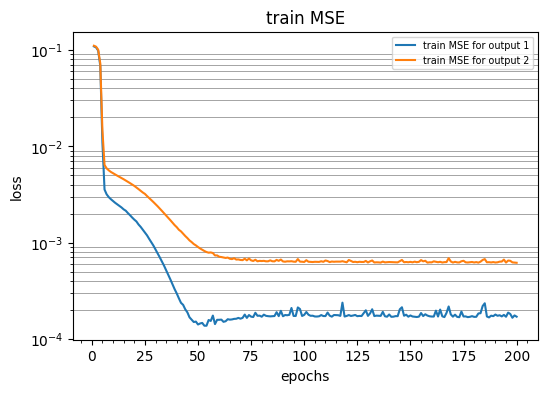

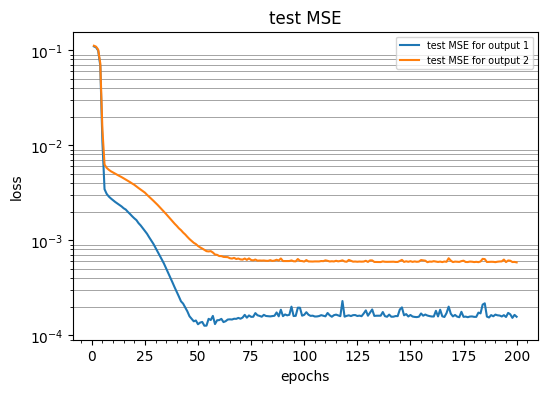

In [57]:
mse_train, mse_test = MSE_calculate(results)
figsize = (6, 4)
plot_MSE(mse_train, 'train', figsize)
plot_MSE(mse_test, 'test', figsize)

regression plot for both test and train and also for each output

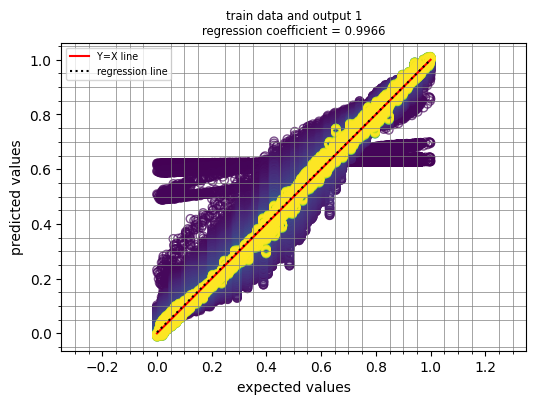

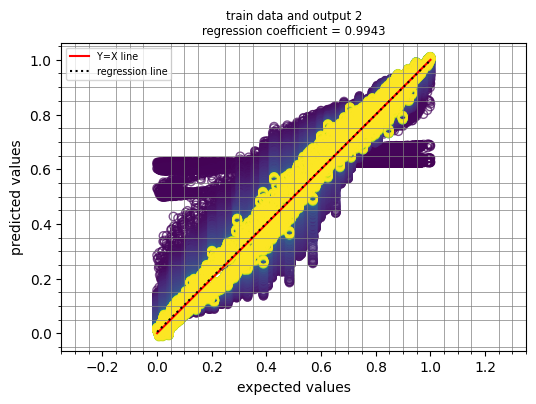

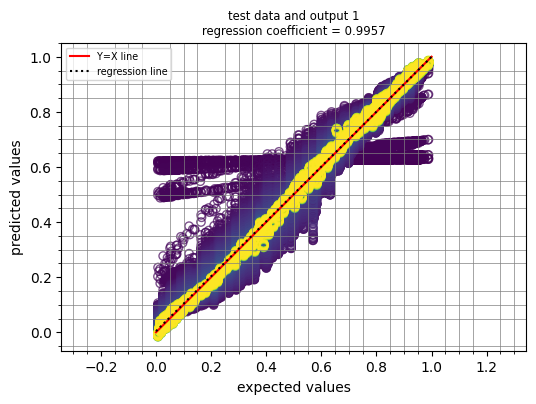

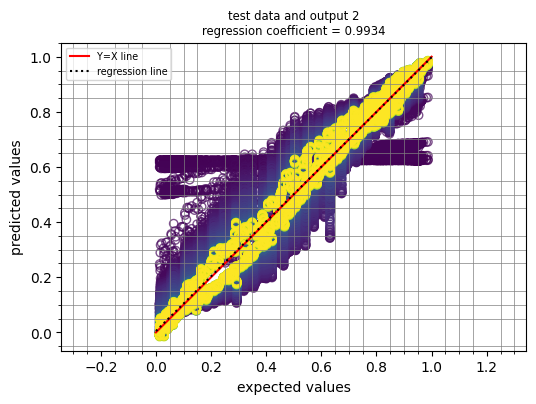

In [58]:
train_result, test_result = results
train_target, train_out = train_result
test_target, test_out = test_result
plot_regression(train_target, train_out, 'train', figsize)
plot_regression(test_target, test_out, 'test', figsize)

plot targets and outputs on same window, also separatly for each output

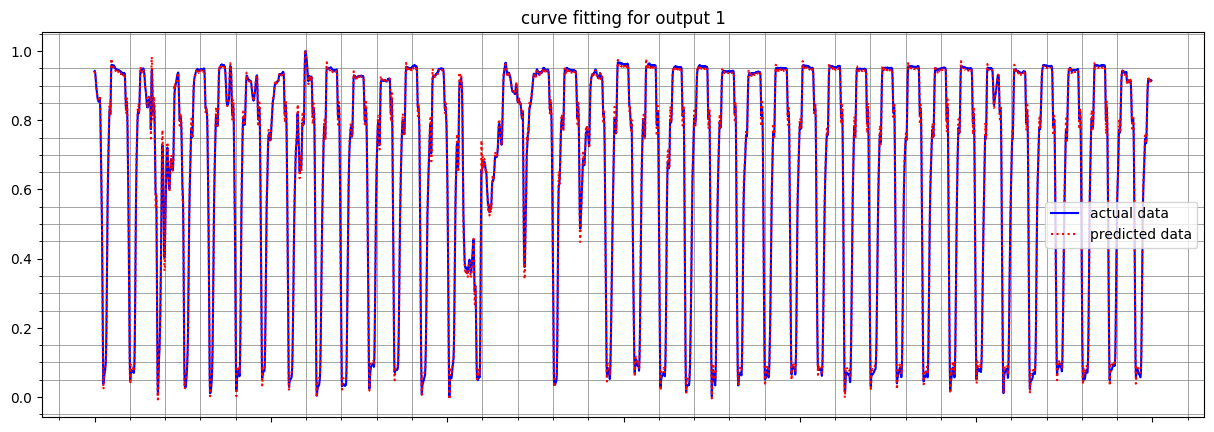

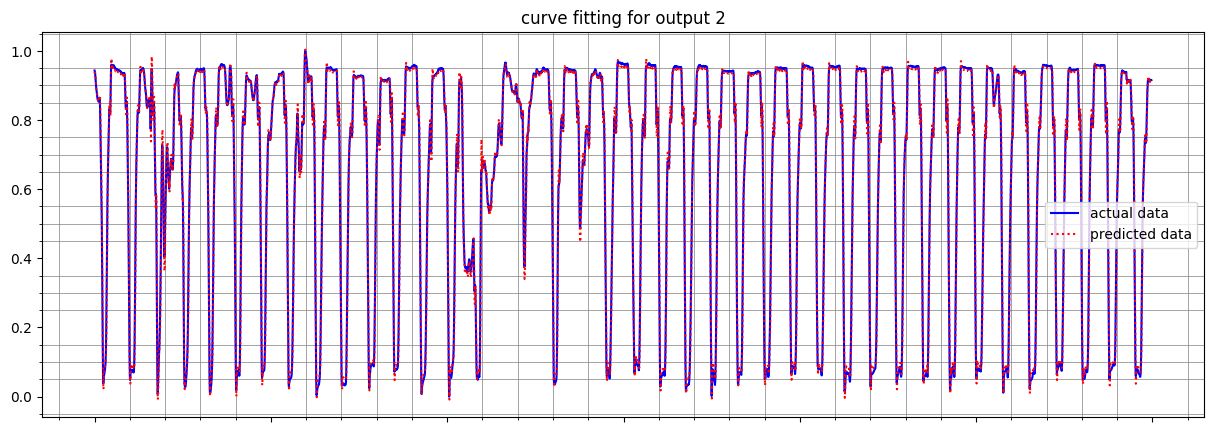

In [59]:
n_rows = np.size(input, axis=0)
predict = np.array([NN(i) for i in input]).reshape((n_rows, n_output))
figsize = (15, 5)
plot_outputs(tar, predict, figsize)

plot cross entropy loss

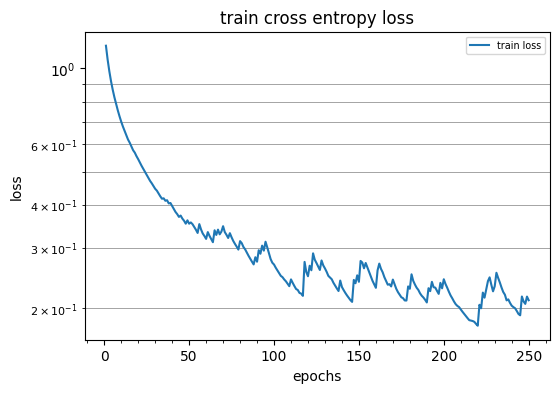

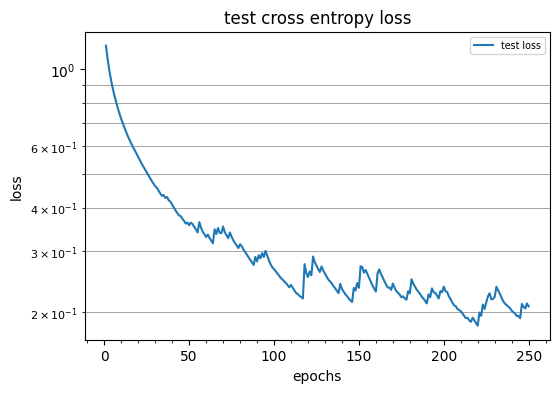

In [60]:
loss_train, loss_test = cross_entropy_calculate(results2)
figsize = (6, 4)
plot_entropy(loss_train, 'train', figsize)
plot_entropy(loss_test, 'test', figsize)

plot confusion matrix

Normalized Confusion Matrix


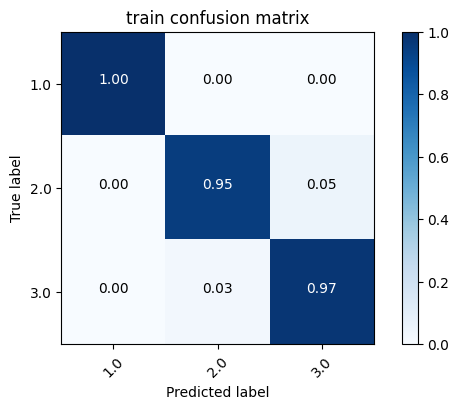

Normalized Confusion Matrix


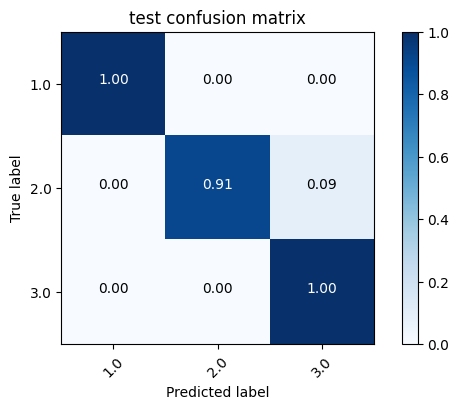

In [61]:
train_result2, test_result2 = results2
train_target2, train_out2 = train_result2
test_target2, test_out2 = test_result2
plot_confusion_matrix(train_target2, train_out2[-1], unique_labels, title='train confusion matrix', normalize=True, figsize=figsize)
plot_confusion_matrix(test_target2, test_out2[-1], unique_labels, title='test confusion matrix', normalize=True, figsize=figsize)

plot data

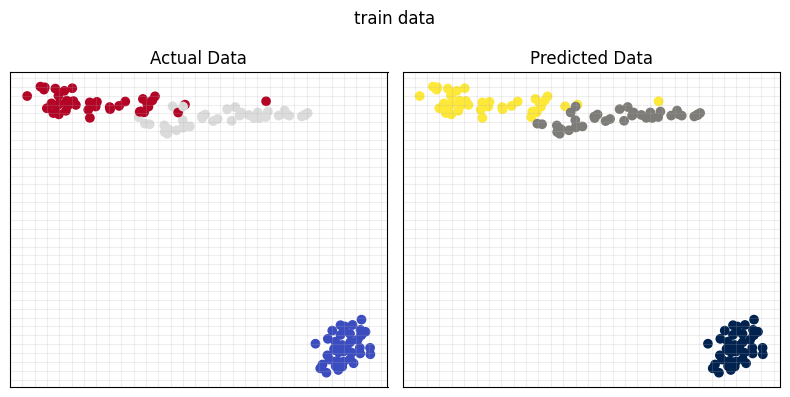

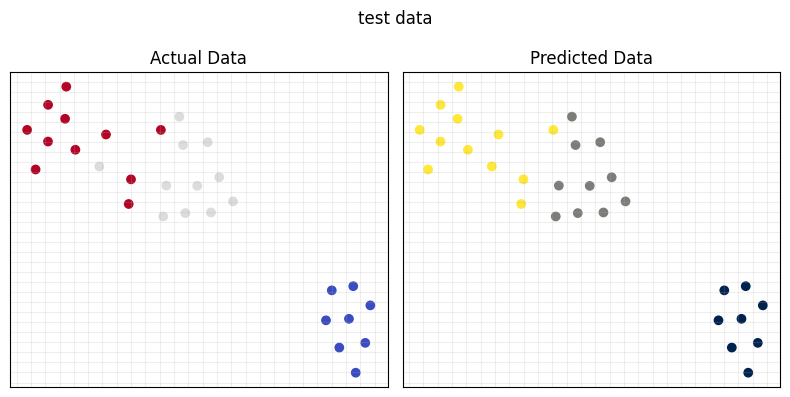

In [62]:
figsize = (8, 4)
train_data, test_data = features
visualize_data(train_data, train_target2, train_out2[-1], 'train data', figsize)
visualize_data(test_data, test_target2, test_out2[-1], 'test data', figsize, perplexity=10)